<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/ODE_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neural Networks to solve Ordinary Diferential Equations



## Intro

The idea of solving an ODE using a Neural Network was firstly described by [Lagaris et al.](https://arxiv.org/abs/physics/9705023)
The insight behind it is basically training a neural network in order to his solution satisfies the conditions required by a differential equation. In other words, we need to find a function whose derivative satisfies the ODE conditions. In this article, we will be going through the underlying mathematical foundations of this concept and then we will implement it using TensorFlow 2.0.

## Mathematical Foundations

Let's say we have an ODE system, given by:

$$u' = f(u,t) , t \in [0,1]$$
$$u(0)=u_0$$

Hence, we can understand the differential operation as a function on the domain $t$ with a known initial condition $u(0)=u_0$.

As we know, Neural Networks are known as universal approximators. We will take advantage of this property of Neural Networks to use them to approximate the solution of the given ODE:

$$NN(t) \approx u(t)$$

Also, we may agree that the derivative of $NN(t)$ will give us a similar equation:

$$NN'(t) = f(NN(t),t)$$

So, if $NN(t)$ is really close to the true solution, then we could say that its derivate is also close to the derivative of the true solution, i.e.:

$$NN'(t) \approx f(u,t) , t \in t$$.

Thus, we can turn this condition into our loss function. We have the given derivative function $f(u,t)$ and we can calculate the Neural Network derivative $NN'(t)$ at each step. This motivates the following loss function (which is the mean squared error of the two values):

$$L = \sqrt{\sum_i \left(\frac{dNN(t_i)}{dt} - f(u,t_i) \right)^2}$$

You may remember the initial condition, we still need to handle that. The most straight-forward way would do this by adding an initial condition term to the cost function. It would look like this:

$$L = \sqrt{(NN(0) - u_0)^2} + \sqrt{\sum_i \left(\frac{dNN(t_i)}{dt} - f(u,t_i) \right)^2}$$

While that would work, it may not be the best approach. We all know the crucial importance of the loss function on the training of the Neural Network, and we also know that the number of terms on this function will impact directly the stability of our training. More terms on the loss function would (usually) imply unstable training.
To avoid it, we can encode the initial condition into the loss in a more efficient way. Let's define a new function and use it instead of directly using the neural network:

$$g(t) = u_0 + tNN(t)$$

It's easy to see that $g(t)$ will always satisfy the initial condition, since $g(0)$ will lead to $tNN(t) = 0$, leaving just the initial condition on the expression($u_t$). This way, we can train $g(t)$ to satisfy the ODE system instead of the Neural Network. Then, it will automatically be a solution to
the derivative function. We can incorporate this new idea into our loss function:

$$L = \sqrt{\sum_i \left(\frac{dg(t_i)}{dt} - f(u(t_i),t_i) \right)^2}$$

## Implementation

We are about to implement the described method in python using the TensorFlow library. In order to have a better understanding of the method, we will use a low-level design, avoiding a number of possible optimizations provided by the library. Our focus, at this moment, is to clearly understand and implement the ODE-solver Neural Network. For this reason, we will also choose a simply ODE:

$$u'= 2x$$
$$u(0)=1$$

We can easily solve this problem by integrating both sides of the solution, leading to $u + C = x^2 +C$, and after fitting $C$ to obey the initial condition
we have $u=x^2 + 1$. Nevertheless, instead of solving it analytically, let's try to solve using Neural Nets.

$$u'= 2x$$
$$ \int u' \,dx = \int 2x \,dx $$
$$ u + C_1 = x^2 + C_2 $$
$$ u = x^2 + C$$

### Define Variables

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
# initial condition
f0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

$$\frac{dg(x)}{x} = \frac{g(x+n)-g(x)}{n},$$
$$lim_{n\to-\infty}$$

In [ ]:
# Create model
def multilayer_perceptron(x):
    x = np.array([[[x]]],  dtype='float32')
    # Hidden fully connected layer with 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    output = tf.matmul(layer_2, weights['out']) + biases['out']
    return output

# Universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

# Given EDO
def f(x):
    return 2*x

# Custom loss function to approximate the derivatives
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

In [ ]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 4215.660645 
loss: 4.349612 
loss: 4.214120 
loss: 4.123478 
loss: 4.045397 
loss: 3.922643 
loss: 3.602313 
loss: 1.470242 
loss: 0.078807 
loss: 0.018429 


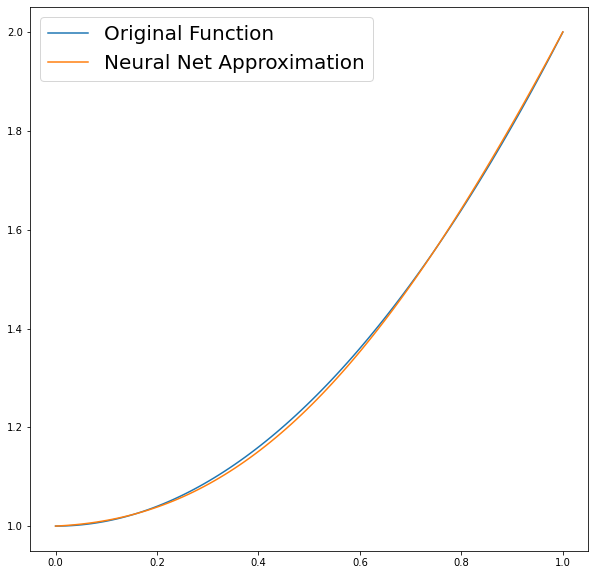

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])

S = true_solution(X)

plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

## Tensorflow.GradientTape instead of Manually computing the finite difference

The same code, but now we are using `tf.GradientTape` to automatically take the derivative for us:

loss: 64.801544 
loss: 9.480783 
loss: 11.196903 
loss: 10.229522 
loss: 13.838994 
loss: 11.268889 
loss: 14.346863 
loss: 10.513601 
loss: 11.187122 
loss: 4.565046 


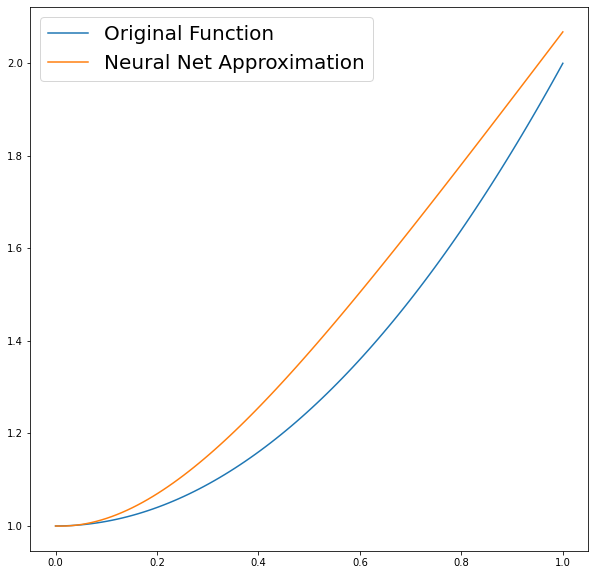

In [ ]:
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}
optimizer = tf.optimizers.SGD(learning_rate)

def train_step_t():
    X = np.linspace(0,1,10)
    with tf.GradientTape(persistent=True) as tape:
        summation = []
        for x in X:
            x = tf.constant([[[x]]],  dtype='float32')
            tape.watch(x)
            g_x = x * multilayer_perceptron(x) + f0
            dNN = tape.gradient(g_x, x)
            summation.append(dNN - f(x))
        loss = tf.reduce_sum(tf.abs(summation))
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

for i in range(training_steps):
    train_step_t()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
result2 = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])


S = true_solution(X)

plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()